In [1]:
#@title FourCastNet imports setup

!pip install xarray pygrib GDAL awscli

# Let pip handle dependencies automatically
!pip install --quiet ai-models-gfs
!pip install --quiet ai-models-fourcastnetv2-gfs
#!pip install --quiet ai-models-panguweather-gfs

!pip install --quiet xarray netcdf4 pygrib matplotlib cartopy

!pip install --quiet basemap basemap-data-hires

import numpy as np
import torch
import xarray as xr
import matplotlib.pyplot as plt

print(f" NumPy: {np.__version__}")
print(f" PyTorch: {torch.__version__}")
print(f" xarray: {xr.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.8/17.8 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 122.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: rsa
    Found existing installation: rsa 4.9.1
    Uninstalling rsa-4.9.1:
      Successfully uninstalled rsa-4.9.1
  Attempting uninstall: docutils
    Found existing installation: docutils 0.21.2
    Uninstalling docutils-0.21.2:
      Successfully uninstalled docutils-0.21.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.2.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
  Preparing metadata (setup.py) 

In [2]:
#@title Pre-install the AI resources
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/gc ./gc/
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/fcnv2 ./fcnv2/
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/pw ./pw/
!aws s3 cp --recursive --no-sign-request s3://noaa-oar-mlwp-data/colab_resources/au ./au/

download: s3://noaa-oar-mlwp-data/colab_resources/gc/stats/stddev_by_level.nc to gc/stats/stddev_by_level.nc
download: s3://noaa-oar-mlwp-data/colab_resources/gc/stats/diffs_stddev_by_level.nc to gc/stats/diffs_stddev_by_level.nc
download: s3://noaa-oar-mlwp-data/colab_resources/gc/stats/mean_by_level.nc to gc/stats/mean_by_level.nc
download: s3://noaa-oar-mlwp-data/colab_resources/gc/params/GraphCast_small - ERA5 1979-2015 - resolution 1.0 - pressure levels 13 - mesh 2to5 - precipitation input and output.npz to gc/params/GraphCast_small - ERA5 1979-2015 - resolution 1.0 - pressure levels 13 - mesh 2to5 - precipitation input and output.npz
download: s3://noaa-oar-mlwp-data/colab_resources/gc/params/GraphCast_operational - ERA5-HRES 1979-2021 - resolution 0.25 - pressure levels 13 - mesh 2to6 - precipitation output only.npz to gc/params/GraphCast_operational - ERA5-HRES 1979-2021 - resolution 0.25 - pressure levels 13 - mesh 2to6 - precipitation output only.npz
download: s3://noaa-oar-m

In [3]:
import pygrib as pg
import ipywidgets as widgets
import math
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib import animation
from mpl_toolkits.basemap import Basemap, shiftgrid
from IPython.display import HTML
from typing import Optional
from netCDF4 import Dataset as DS
import os

# **Run FourCastNetv2-small**
Fourier Forecasting Neural Network, is a global data-driven weather forecasting model that provides accurate short to medium-range global predictions at 0.25∘ resolution. FourCastNet accurately forecasts high-resolution, fast-timescale variables such as the surface wind speed, precipitation, and atmospheric water vapor. It has important implications for planning wind energy resources, predicting extreme weather events such as tropical cyclones, extra-tropical cyclones, and atmospheric rivers. FourCastNet matches the forecasting accuracy of the ECMWF Integrated Forecasting System (IFS), a state-of-the-art Numerical Weather Prediction (NWP) model, at short lead times for large-scale variables, while outperforming IFS for variables with complex fine-scale structure, including precipitation. FourCastNet generates a week-long forecast in less than 2 seconds, orders of magnitude faster than IFS. The speed of FourCastNet enables the creation of rapid and inexpensive large-ensemble forecasts with thousands of ensemble-members for improving probabilistic forecasting. We discuss how data-driven deep learning models such as FourCastNet are a valuable addition to the meteorology toolkit to aid and augment NWP models. (https://arxiv.org/abs/2202.11214)

Github: https://github.com/ecmwf-lab/ai-models-fourcastnetv2



In [4]:
# (optional): run if next cell doesn't work
!pip uninstall -y ai-models-fourcastnetv2-gfs
!pip install --no-cache-dir ai-models-fourcastnetv2-gfs

Found existing installation: ai-models-fourcastnetv2-gfs 0.0.7
Uninstalling ai-models-fourcastnetv2-gfs-0.0.7:
  Successfully uninstalled ai-models-fourcastnetv2-gfs-0.0.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 176.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.5
    Uninstalling numpy-2.3.5:
      Successfully uninstalled numpy-2.3.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
basemap 2.0.0 requires numpy<2.4,>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have n

In [5]:
#@title Run FourCastNetv2-small

model = "fourcastnetv2-small"
output_path = f"./{model}_20220101_0000"
model2assets = {
    "fourcastnetv2-small":"./fcnv2"
}
assets = model2assets[model]

#Modify high resolution case down to 48hrs (from 240)
!ai-models-gfs --input "gfs" --date "20220101" --time "0000" --assets {assets} --path {output_path} --lead "72" "fourcastnetv2-small"

2025-12-18 14:49:13,731 INFO Writing results to ./fourcastnetv2-small_20220101_0000
2025-12-18 14:49:13,732 INFO Loading ./fcnv2/global_means.npy
2025-12-18 14:49:13,732 INFO Loading ./fcnv2/global_stds.npy
2025-12-18 14:49:13,733 INFO Loading surface fields from GFS
2025-12-18 14:49:21,926 INFO Downloading https://noaa-gfs-bdp-pds.s3.amazonaws.com/gfs.20220101/00/atmos/gfs.t00z.pgrb2.0p25.f000
2025-12-18 14:49:59,321 INFO Loading pressure fields from GFS
2025-12-18 14:50:43,339 INFO Using device 'CUDA'. The speed of inference depends greatly on the device.
2025-12-18 14:51:02,353 INFO Starting date is 2022-01-01 00:00:00
2025-12-18 14:51:02,353 INFO Writing input fields
2025-12-18 14:51:03,916 INFO Writing step 0: 1 second.
2025-12-18 14:51:03,917 INFO Model initialisation: 1 minute 50 seconds
2025-12-18 14:51:03,917 INFO Starting inference for 12 steps (72h).
/usr/local/lib/python3.12/dist-packages/ai_models_fourcastnetv2_gfs/fourcastnetv2/layers.py:623: FutureWarning: `torch.cuda.am

In [6]:
#@title Quick check of GRIB2 output "fourcastnetv2-small_20220101_0000"
print(os.listdir())

['.config', 'fcnv2', 'au', 'pw', 'fourcastnetv2-small_20220101_0000', 'gc', 'sample_data']


In [7]:
#@title Convert from GRIB2 to netcdf for visualization if desired (6 mins)

date = "20220101"
time = "0000"
model = "fourcastnetv2-small"
input_data = "gfs"
output_path = f"./{model}_{date}_{time}"
print(output_path)
forecast_lead = "72"

# Define the main function to convert GRIB files to NetCDF
def grib2nc(model, path, lead, step, date, time, inputmodel):

    # Mapping of variable names and their descriptions/units
    path = "fourcastnetv2-small_20220101_0000"
    varmap = {
        "u10": ['10 metre U wind component', 'm s-1'],
        "v10": ['10 metre V wind component', 'm s-1'],
        "t2": ['2 metre temperature', 'K'],
        "msl": ['Pressure reduced to MSL', 'Pa'],
        "u100": ['100 metre U wind component', 'm s-1'],
        "v100": ['100 metre V wind component', 'm s-1'],
        "sp": ['Surface pressure', 'Pa'],
        "tcwv": ['Precipitable water', 'kg m-2'],
        "apcp": ['6-hr accumulated precipitation', 'm'],
        "u": ['U component of wind', 'm s-1'],
        "v": ['V component of wind', 'm s-1'],
        "t": ['Temperature', 'K'],
        "z": ['Geopotential', 'm2 s-2'],
        "r": ['Relative humidity', '%'],
        "q": ['Specific humidity', 'kg kg-1'],
        "w": ['Vertical velocity', 'Pa s-1']
    }

    # Mapping from ECMWF to GFS names
    ec2gfsmap = {
        "u": "u",
        "v": "v",
        "w": "w",
        "z": "z",
        "q": "q",
        "r": "r",
        "t": "t",
        "10u": "u10",
        "10v": "v10",
        "100u": "u100",
        "100v": "v100",
        "2t": "t2",
        "msl": "msl",
        "sp": "sp",
        "tcwv": "tcwv",
        "tp": "apcp"
    }

    # Initialize lists to store variables and levels
    unique_pl_vars = []
    unique_sfc_vars = []
    levels = []

    # Open the GRIB file and extract grid shape and lat/lon coordinates
    with pg.open(path) as grib:
        print(len(grib))
        #for grb in grib:
        #  print(grb)
        y_shape, x_shape = grib[1].values.shape
        lats, lons = grib[1].latlons()
        lats = lats[:, 0]
        lons = lons[0, :]

        # Identify pressure level and surface variables
        for grb in grib:
            if grb.levelType == "pl":
                if grb.level not in levels:
                    levels.append(grb.level)
                if grb.shortName not in unique_pl_vars:
                    unique_pl_vars.append(grb.shortName)
            else:
                if grb.shortName not in unique_sfc_vars:
                    unique_sfc_vars.append(grb.shortName)
        levels.sort(reverse=True)
        levelmap = {level: c for c, level in enumerate(levels)}

        # Create NetCDF file and define dimensions
        f = DS(f"{path}.nc", 'w', format='NETCDF4')
        f.createDimension('time', lead // step + 1)
        f.createDimension('level', len(levels))
        f.createDimension('longitude', x_shape)
        f.createDimension('latitude', y_shape)

        # Generate time values based on initialization date and time
        initdt = datetime.datetime.strptime(f"{date}{time}", "%Y%m%d%H00")
        times = np.array([
            int((initdt + datetime.timedelta(hours=int(i))).timestamp())
            for i in np.arange(0, lead + step, step)
        ])

        # Create coordinate variables in NetCDF
        create_variable_nochunk(f, 'time', ('time',), times, {
            'long_name': 'Date and Time', 'units': 'seconds since 1970-1-1',
            'calendar': 'standard'
        })
        create_variable_nochunk(f, 'longitude', ('longitude',), lons, {
            'long_name': 'Longitude', 'units': 'degree'
        })
        create_variable_nochunk(f, 'latitude', ('latitude',), lats, {
            'long_name': 'Latitude', 'units': 'degree'
        })
        create_variable_nochunk(f, 'level', ('level',), np.array(levels), {
            'long_name': 'Isobaric surfaces', 'units': 'hPa'
        })

        # Define variables in NetCDF for both pressure level and surface variables
        for variable in unique_pl_vars + unique_sfc_vars:
            dims = ('time', 'level', 'latitude', 'longitude') if variable in unique_pl_vars else ('time', 'latitude', 'longitude')
            chunksizes = (1, 1, y_shape, x_shape) if 'level' in dims else (1, y_shape, x_shape)
            gfsequivalent = ec2gfsmap[variable]
            create_variable(
                f, gfsequivalent, dims, None, {
                    'long_name': varmap[gfsequivalent][0],
                    'units': varmap[gfsequivalent][1]
                },
                chunksizes
            )

        # Populate NetCDF variables with data from GRIB
        grib.seek(0)
        for grb in grib:
            shortName = grb.shortName
            timestep = int(grb.step / step)
            level = grb.level
            levelType = grb.levelType
            if (shortName == 'z' and levelType == 'sfc') or shortName not in ec2gfsmap.keys():
                continue
            gfsequivalent = ec2gfsmap[shortName]
            vals = grb.values

            if levelType == 'pl':
                levelind = levelmap[level]
                f.variables[gfsequivalent][timestep, levelind, :, :] = vals
            elif levelType == 'sfc':
                f.variables[gfsequivalent][timestep, :, :] = vals

        # Add global attributes to the NetCDF file
        f.Conventions = 'CF-1.8'
        f.version = '3_2025-02-20'
        f.model_name = model
        f.initialization_model = inputmodel
        f.initialization_time = initdt.strftime('%Y-%m-%dT%H:%M:%S')
        f.first_forecast_hour = "0"
        f.last_forecast_hour = f"{lead}"
        f.forecast_hour_step = f"6"
        f.creation_time = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')
        f.close()

# Functions to create variables in the NetCDF file
def create_variable(f, name, dimensions, data, attrs, chunksizes):
    dtype = 'i4' if name in ['time', 'level'] else 'f4'
    var = f.createVariable(name, dtype, dimensions, compression='zlib', complevel=2, chunksizes=chunksizes)
    if data is not None:
        var[:] = data
    for attr_name, attr_value in attrs.items():
        var.setncattr(attr_name, attr_value)

def create_variable_nochunk(f, name, dimensions, data, attrs):
    dtype = 'i4' if name in ['time', 'level'] else 'f4'
    var = f.createVariable(name, dtype, dimensions, compression='zlib', complevel=2)
    var[:] = data
    for attr_name, attr_value in attrs.items():
        var.setncattr(attr_name, attr_value)

#Call the function
grib2nc(model, output_path, int(forecast_lead), 6, date, time, input_data)
!rm {output_path}
print("Conversion complete")


./fourcastnetv2-small_20220101_0000
949


/tmp/ipython-input-3906475769.py:152: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  f.creation_time = datetime.datetime.utcnow().strftime('%Y-%m-%dT%H:%M:%S')


Conversion complete


In [8]:
variable_levels = {
    # Surface variables
    'msl': {'min': 97500, 'max': 102500, 'name': 'mean sea level pressure', 'units': 'Pa'},
    'u10': {'min': -25, 'max': 25, 'name': '10m U wind component', 'units': 'm/s'},
    'v10': {'min': -25, 'max': 25, 'name': '10m V wind component', 'units': 'm/s'},
    'u100': {'min': -30, 'max': 30, 'name': '100m U wind component', 'units': 'm/s'},
    'v100': {'min': -30, 'max': 30, 'name': '100m V wind component', 'units': 'm/s'},
    't2': {'min': 179, 'max': 321, 'name': '2m temperature', 'units': 'K'},
    'tcwv': {'min': 0, 'max': 70, 'name': 'total column water vapor', 'units': 'kg/m²'},
    'sp': {'min': 75000, 'max': 105000, 'name': 'surface pressure', 'units': 'Pa'},
    'apcp': {'min': 0, 'max': 5, 'name': 'total precipitation', 'units': 'm'},

    # Geopotential height (z) variables
    'z50': {'min': 168000, 'max': 213000, 'name': 'geopotential at 50 hPa', 'units': 'm^2/s^2'},
    'z100': {'min': 133000, 'max': 166000, 'name': 'geopotential at 100 hPa', 'units': 'm^2/s^2'},
    'z150': {'min': 109000, 'max': 143000, 'name': 'geopotential at 150 hPa', 'units': 'm^2/s^2'},
    'z200': {'min': 92000, 'max': 124000, 'name': 'geopotential at 200 hPa', 'units': 'm^2/s^2'},
    'z250': {'min': 80000, 'max': 109000, 'name': 'geopotential at 250 hPa', 'units': 'm^2/s^2'},
    'z300': {'min': 69300, 'max': 96400, 'name': 'geopotential at 300 hPa', 'units': 'm^2/s^2'},
    'z400': {'min': 52600, 'max': 75700, 'name': 'geopotential at 400 hPa', 'units': 'm^2/s^2'},
    'z500': {'min': 39200, 'max': 58900, 'name': 'geopotential at 500 hPa', 'units': 'm^2/s^2'},
    'z600': {'min': 28400, 'max': 44600, 'name': 'geopotential at 600 hPa', 'units': 'm^2/s^2'},
    'z700': {'min': 19200, 'max': 32300, 'name': 'geopotential at 700 hPa', 'units': 'm^2/s^2'},
    'z850': {'min': 6640, 'max': 16400, 'name': 'geopotential at 850 hPa', 'units': 'm^2/s^2'},
    'z925': {'min': 1600, 'max': 9600, 'name': 'geopotential at 925 hPa', 'units': 'm^2/s^2'},
    'z1000': {'min': -4000, 'max': 4000, 'name': 'geopotential at 1000 hPa', 'units': 'm^2/s^2'},

    # Temperature (t) variables
    't50': {'min': 180, 'max': 240, 'name': 'temperature at 50 hPa', 'units': 'K'},
    't100': {'min': 187, 'max': 237, 'name': 'temperature at 100 hPa', 'units': 'K'},
    't150': {'min': 190, 'max': 240, 'name': 'temperature at 150 hPa', 'units': 'K'},
    't200': {'min': 193, 'max': 243, 'name': 'temperature at 200 hPa', 'units': 'K'},
    't250': {'min': 196, 'max': 243, 'name': 'temperature at 250 hPa', 'units': 'K'},
    't300': {'min': 196, 'max': 252, 'name': 'temperature at 300 hPa', 'units': 'K'},
    't400': {'min': 203, 'max': 266, 'name': 'temperature at 400 hPa', 'units': 'K'},
    't500': {'min': 209, 'max': 281, 'name': 'temperature at 500 hPa', 'units': 'K'},
    't600': {'min': 211, 'max': 293, 'name': 'temperature at 600 hPa', 'units': 'K'},
    't700': {'min': 202, 'max': 302, 'name': 'temperature at 700 hPa', 'units': 'K'},
    't850': {'min': 198, 'max': 313, 'name': 'temperature at 850 hPa', 'units': 'K'},
    't925': {'min': 201, 'max': 319, 'name': 'temperature at 925 hPa', 'units': 'K'},
    't1000': {'min': 204, 'max': 323, 'name': 'temperature at 1000 hPa', 'units': 'K'},

    # Wind (u and v) components
    'u50':{'min': -70, 'max': 70, 'name': 'U wind component at 50 hPa', 'units': 'm/s'},
    'u100':{'min': -70, 'max': 70, 'name': 'U wind component at 100 hPa', 'units': 'm/s'},
    'u150':{'min': -70, 'max': 70, 'name': 'U wind component at 150 hPa', 'units': 'm/s'},
    'u200':{'min': -70, 'max': 70, 'name': 'U wind component at 200 hPa', 'units': 'm/s'},
    'u250':{'min': -70, 'max': 70, 'name': 'U wind component at 250 hPa', 'units': 'm/s'},
    'u300':{'min': -70, 'max': 70, 'name': 'U wind component at 300 hPa', 'units': 'm/s'},
    'u400':{'min': -50, 'max': 50, 'name': 'U wind component at 400 hPa', 'units': 'm/s'},
    'u500':{'min': -50, 'max': 50, 'name': 'U wind component at 500 hPa', 'units': 'm/s'},
    'u600':{'min': -40, 'max': 40, 'name': 'U wind component at 600 hPa', 'units': 'm/s'},
    'u700':{'min': -40, 'max': 40, 'name': 'U wind component at 700 hPa', 'units': 'm/s'},
    'u850':{'min': -30, 'max': 30, 'name': 'U wind component at 850 hPa', 'units': 'm/s'},
    'u925':{'min': -30, 'max': 30, 'name': 'U wind component at 925 hPa', 'units': 'm/s'},
    'u1000':{'min': -30, 'max': 30, 'name': 'U wind component at 1000 hPa', 'units': 'm/s'},

    'v50':{'min': -70, 'max': 70, 'name': 'V wind component at 50 hPa', 'units': 'm/s'},
    'v100':{'min': -70, 'max': 70, 'name': 'V wind component at 100 hPa', 'units': 'm/s'},
    'v150':{'min': -70, 'max': 70, 'name': 'V wind component at 150 hPa', 'units': 'm/s'},
    'v200':{'min': -70, 'max': 70, 'name': 'V wind component at 200 hPa', 'units': 'm/s'},
    'v250':{'min': -70, 'max': 70, 'name': 'V wind component at 250 hPa', 'units': 'm/s'},
    'v300':{'min': -70, 'max': 70, 'name': 'V wind component at 300 hPa', 'units': 'm/s'},
    'v400':{'min': -50, 'max': 50, 'name': 'V wind component at 400 hPa', 'units': 'm/s'},
    'v500':{'min': -50, 'max': 50, 'name': 'V wind component at 500 hPa', 'units': 'm/s'},
    'v600':{'min': -40, 'max': 40, 'name': 'V wind component at 600 hPa', 'units': 'm/s'},
    'v700':{'min': -40, 'max': 40, 'name': 'V wind component at 700 hPa', 'units': 'm/s'},
    'v850':{'min': -30, 'max': 30, 'name': 'V wind component at 850 hPa', 'units': 'm/s'},
    'v925':{'min': -30, 'max': 30, 'name': 'V wind component at 925 hPa', 'units': 'm/s'},
    'v1000':{'min': -30, 'max': 30, 'name': 'V wind component at 1000 hPa', 'units': 'm/s'},

    #specific humidity (q)
    'q50':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 50 hPa', 'units': 'kg/kg'},
    'q100':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 100 hPa', 'units': 'kg/kg'},
    'q150':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 150 hPa', 'units': 'kg/kg'},
    'q200':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 200 hPa', 'units': 'kg/kg'},
    'q250':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 250 hPa', 'units': 'kg/kg'},
    'q300':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 300 hPa', 'units': 'kg/kg'},
    'q400':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 400 hPa', 'units': 'kg/kg'},
    'q500':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 500 hPa', 'units': 'kg/kg'},
    'q600':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 600 hPa', 'units': 'kg/kg'},
    'q700':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 700 hPa', 'units': 'kg/kg'},
    'q850':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 850 hPa', 'units': 'kg/kg'},
    'q925':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 925 hPa', 'units': 'kg/kg'},
    'q1000':{'min': 0, 'max': 0.032, 'name': 'specific humidity at 1000 hPa', 'units': 'kg/kg'},

    # relative Humidity (r)
    **{f'r{level}': {'min': 0, 'max': 100, 'name': f'relative humidity at {level} hPa', 'units': '%'}
       for level in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]},

    # Vertical Velocity (w)
    **{f'w{level}': {'min': -1, 'max': 1, 'name': f'vertical velocity at {level} hPa', 'units': 'm/s'}
       for level in [50, 100, 150, 200, 250, 300, 400, 500, 600, 700, 850, 925, 1000]}
}


In [9]:
#@title Quick check of netcdf output "fourcastnetv2-small_20220101_0000.nc"
print(os.listdir())

['.config', 'fourcastnetv2-small_20220101_0000.nc', 'fcnv2', 'au', 'pw', 'gc', 'sample_data']


In [10]:
#@title Visualize Fourcastnetv2 small

#Which variable you want to plot and at what pressure level (if appropriate)
#See table for variable options by model
variable = "t2"
level = 0

#This bounds the plot (currently set to global)
lat_bounds = (-90,90)
lon_bounds = (-180,180)

#Make the plot bigger or smaller
plot_size = 6

#Colormap (non-diverging variables)
colormap = 'viridis'

with xr.open_dataset(f"{output_path}.nc") as data_xr:
    print(data_xr)
    if level!=0:
        varlevel = variable + str(level)
        data_sub = data_xr[variable].sel(level=level).load()
    else:
        varlevel = variable
        data_sub = data_xr[variable].load()

print(variable_levels)
max_val = variable_levels[varlevel]['max']
min_val = variable_levels[varlevel]['min']
levels = np.linspace(min_val,max_val,21)
variable_name = variable_levels[varlevel]['name']
units = variable_levels[varlevel]['units']

#These are the variables that need diverging color map
if variable in ['u10','v10','u100','v100','u','v','w']:
  center = 1
  colormap = "bwr"
else:
  center = None
  colormap = colormap

def convert_longitudes(lon):
    lon = np.asarray(lon)
    lon = ((lon + 180) % 360) - 180
    return lon

def plot_data(
        data_sub,
        plot_size,
        lat_bounds,
        lon_bounds,
        levels,
        steps,
        colormap,
        variable_name,
        variable_units,
        time_steps=None
        ):


    # Precompute shifted data for all frames to avoid recalculating in the animation loop
    plot_data_shifted_all = [
        shiftgrid(
            180,
            data_sub.isel(time=frame, missing_dims="ignore").values,
            data_sub.coords['longitude'].values,
            start=False
        )[0]
        for frame in range(steps)
    ]
    # Calculate the aspect ratio based on latitude and longitude bounds
    lat_extent = lat_bounds[1] - lat_bounds[0]
    lon_extent = lon_bounds[1] - lon_bounds[0]
    aspect_ratio = lon_extent / lat_extent

    # Dynamically adjust the figure size based on the aspect ratio
    figure_width = plot_size * aspect_ratio
    figure_height = plot_size
    figure = plt.figure(figsize=(figure_width, figure_height))

    figure.subplots_adjust(left=0, right=1, top=0.90, bottom=0.10, wspace=0, hspace=0)

    ax = figure.add_subplot(1, 1, 1)
    ax.set_xticks([])
    ax.set_yticks([])

    # Convert longitudes
    lon = data_sub.coords['longitude'].values
    lat = data_sub.coords['latitude'].values
    plot_data_shifted, lon_shifted = shiftgrid(180, plot_data_shifted_all[0], lon, start=False)

    # Create basemap with specified bounds
    m = Basemap(projection='cyl', resolution='i', ax=ax,
                llcrnrlat=lat_bounds[0], urcrnrlat=lat_bounds[1],
                llcrnrlon=lon_bounds[0], urcrnrlon=lon_bounds[1])
    m.drawcoastlines()
    m.drawcountries()

    lon_shifted, lat_shifted = np.meshgrid(lon_shifted, lat)
    x, y = m(lon_shifted, lat_shifted)

    # Define levels and BoundaryNorm
    norm = matplotlib.colors.BoundaryNorm(levels, ncolors=256)

    # Initialize the plot with the first frame
    im = m.pcolormesh(x, y, plot_data_shifted, norm=norm, cmap=colormap, shading="auto")
    cbar = plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="horizontal",
        pad=0.02,
        aspect=16,
        shrink=0.65,
        cmap=colormap,
        extend="neither")
    cbar.set_label(f"{variable_name} ({variable_units})")

    title = ax.set_title(f"{variable_name} at Timestep 0")

    # Update function for animation
    def update(frame):
        im.set_array(plot_data_shifted_all[frame].flatten())
        timestep = time_steps[frame] if time_steps is not None else frame
        title.set_text(f"{variable_name} at {timestep} hours")

    ani = animation.FuncAnimation(
        fig=figure, func=update, frames=steps, interval=250
    )
    plt.close(figure.number)
    return HTML(ani.to_jshtml())

plot_data(data_sub, plot_size, lat_bounds,lon_bounds,
          levels,13, colormap, variable_name, units,


          time_steps=[i * 6 for i in range(13)])

<xarray.Dataset> Size: 4GB
Dimensions:    (time: 13, level: 13, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 104B 2022-01-01 ... 2022-01-04
  * level      (level) int32 52B 1000 925 850 700 600 500 ... 250 200 150 100 50
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables: (12/13)
    u          (time, level, latitude, longitude) float32 702MB ...
    v          (time, level, latitude, longitude) float32 702MB ...
    z          (time, level, latitude, longitude) float32 702MB ...
    t          (time, level, latitude, longitude) float32 702MB ...
    r          (time, level, latitude, longitude) float32 702MB ...
    u10        (time, latitude, longitude) float32 54MB ...
    ...         ...
    u100       (time, latitude, longitude) float32 54MB ...
    v100       (time, latitude, longitude) float32 54MB ...
    t2         (time, 

In [15]:
#@title Setup CDS API and Download Ground Truth

import os

# Install CDS API
!pip install cdsapi

# Configure CDS API credentials
with open(os.path.expanduser("~/.cdsapirc"), "w") as f:
    f.write("url: https://cds.climate.copernicus.eu/api\n")
    f.write("key: 20562f3b-4ae8-4ccd-a591-53fe49f2bdcd\n")

# Verify configuration
!cat ~/.cdsapirc

# Download ground truth for forecast
INIT_DATE = "20220101"  #  forecast initialization date
INIT_TIME = "0000"      #  forecast initialization time
LEAD_HOURS = 72         #  forecast lead time

print(f"\nDownloading ERA5 ground truth for forecast: {INIT_DATE} {INIT_TIME} + {LEAD_HOURS}h")

import sys
from datetime import datetime, timedelta
import cdsapi

# Calculate valid time
init_dt = datetime.strptime(f"{INIT_DATE}{INIT_TIME}", "%Y%m%d%H%M")
valid_dt = init_dt + timedelta(hours=LEAD_HOURS)

output_file = f"era5_truth_{valid_dt.strftime('%Y%m%d_%H')}.nc"

print(f"Valid time: {valid_dt.strftime('%Y-%m-%d %H:%M UTC')}")
print(f"Downloading to: {output_file}")

# Initialize CDS client
c = cdsapi.Client()

# Download surface variables
c.retrieve(
        'reanalysis-era5-single-levels',
        {
            'product_type': 'reanalysis',
            'variable': [
                '2m_temperature',
                '10m_u_component_of_wind',
                '10m_v_component_of_wind',
                'mean_sea_level_pressure',
            ],
            'year': valid_dt.strftime('%Y'),
            'month': valid_dt.strftime('%m'),
            'day': valid_dt.strftime('%d'),
            'time': valid_dt.strftime('%H:00'),
            'format': 'netcdf',
        },
        output_file
    )
print(f"\n Successfully downloaded: {output_file}")

    # Verify the download
import xarray as xr
ds = xr.open_dataset(output_file)
print(f"\nDownloaded variables: {list(ds.data_vars)}")
print(f"Grid size: {len(ds.latitude)} x {len(ds.longitude)}")
ds.close()

url: https://cds.climate.copernicus.eu/api
key: 20562f3b-4ae8-4ccd-a591-53fe49f2bdcd

Valid time: 2022-01-04 00:00 UTC


2025-12-18 15:09:16,659 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
INFO:ecmwf.datastores.legacy_client:[2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-12-18 15:09:17,442 INFO [2025-12-11T00:00:00] Please note that a dedicated catalogue entry for this dataset, post-processed and stored in Analysis Ready Cloud Optimized (ARCO) format (Zarr), is available for optimised time-series retrievals (i.e. for retrieving data from selected variables for a single point over an extended period of time in an efficient way). You can discover it [here](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-timeseries?tab=overview)
INFO:ecmwf.datastores.legacy_client:[2025-12-11T00:00:00] Please note that a dedicated catalogue entr

8d82fcb435e141690ddb16219506d7f3.nc:   0%|          | 0.00/6.64M [00:00<?, ?B/s]


 Successfully downloaded: era5_truth_20220104_00.nc

Downloaded variables: ['t2m', 'u10', 'v10', 'msl']
Grid size: 721 x 1440


FOURCASTNET QUANTITATIVE EVALUATION

[1/4] Loading datasets...
    Loaded forecast: fourcastnetv2-small_20220101_0000.nc
    Variables: ['u', 'v', 'z', 't', 'r', 'u10', 'v10', 'u100', 'v100', 't2', 'sp', 'msl', 'tcwv']
    Dimensions: {'time': 13, 'level': 13, 'latitude': 721, 'longitude': 1440}
    Loaded truth: era5_truth_20220104_00.nc
    Variables: ['t2m', 'u10', 'v10', 'msl']
    Dimensions: {'valid_time': 1, 'latitude': 721, 'longitude': 1440}

[2/4] Aligning spatial grids...
   Grid size: 721 x 1440

[3/4] Computing evaluation metrics...
Evaluating t2 (forecast) vs t2m (truth)...
  Shapes: pred=(721, 1440), truth=(721, 1440)
Evaluating u10 (forecast) vs u10 (truth)...
  Shapes: pred=(721, 1440), truth=(721, 1440)
Evaluating v10 (forecast) vs v10 (truth)...
  Shapes: pred=(721, 1440), truth=(721, 1440)
Evaluating msl (forecast) vs msl (truth)...
  Shapes: pred=(721, 1440), truth=(721, 1440)

[4/4] RESULTS:
Forecast_Var Truth_Var       RMSE        MAE       Bias  Correlation  Val

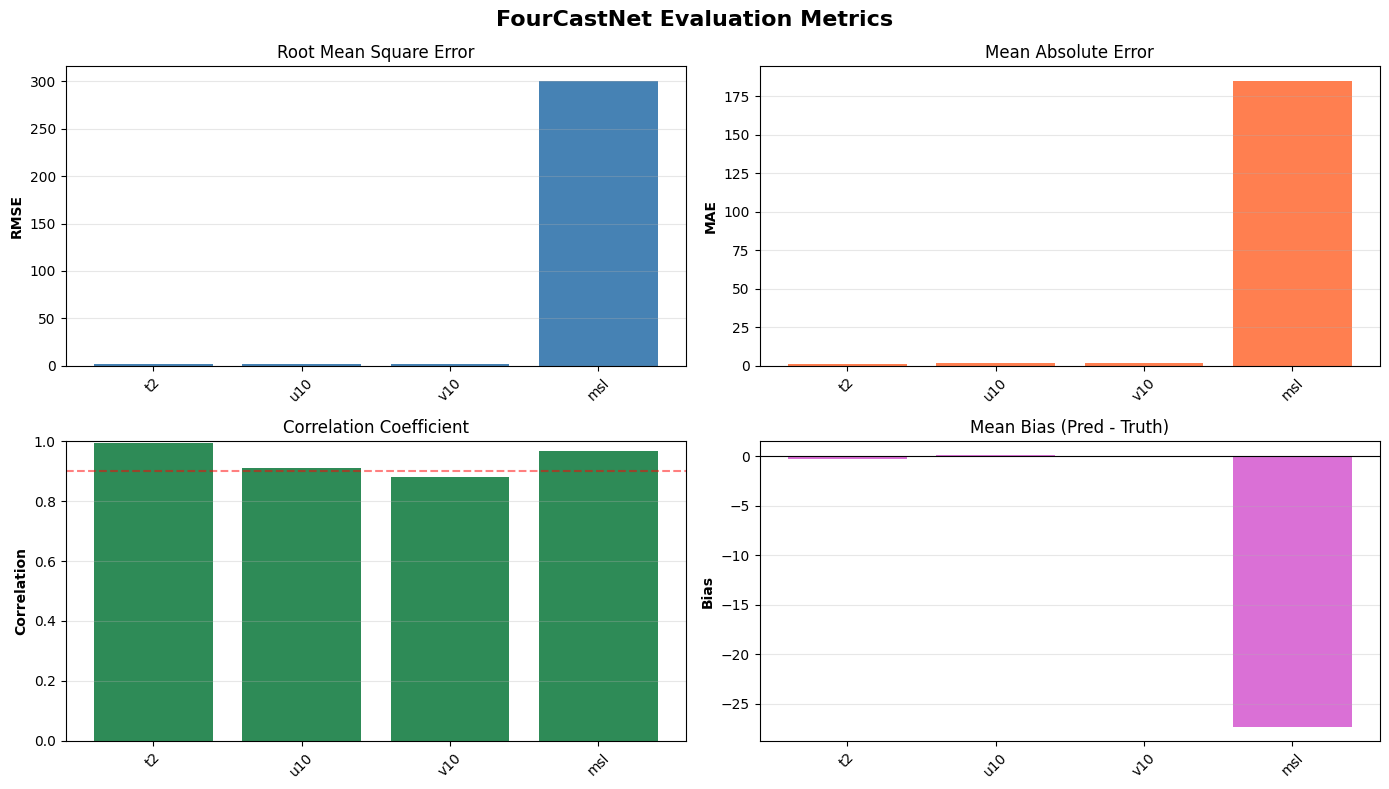

   Saved: fourcastnet_metrics_summary.png


In [17]:
#@title FourCastNet Quantitative Evaluation with RMSE

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import warnings

FORECAST_FILE = 'fourcastnetv2-small_20220101_0000.nc'
TRUTH_FILE = 'era5_truth_20220104_00.nc'

VARIABLE_MAPPING = {
    't2': 't2m',    # FourCastNet -> ERA5
    'u10': 'u10',
    'v10': 'v10',
    'msl': 'msl',
}

CREATE_PLOTS = True

# Helper functions
def compute_rmse(pred, truth):
    pred_flat = pred.flatten()
    truth_flat = truth.flatten()

    valid_mask = ~(np.isnan(pred_flat) | np.isnan(truth_flat))
    if valid_mask.sum() == 0:
        return np.nan
    diff = pred_flat[valid_mask] - truth_flat[valid_mask]
    return np.sqrt(np.mean(diff ** 2))

def compute_mae(pred, truth):
    pred_flat = pred.flatten()
    truth_flat = truth.flatten()

    valid_mask = ~(np.isnan(pred_flat) | np.isnan(truth_flat))
    if valid_mask.sum() == 0:
        return np.nan
    return np.mean(np.abs(pred_flat[valid_mask] - truth_flat[valid_mask]))

def compute_bias(pred, truth):
    pred_flat = pred.flatten()
    truth_flat = truth.flatten()

    valid_mask = ~(np.isnan(pred_flat) | np.isnan(truth_flat))
    if valid_mask.sum() == 0:
        return np.nan
    return np.mean(pred_flat[valid_mask] - truth_flat[valid_mask])

def compute_correlation(pred, truth):
    pred_flat = pred.flatten()
    truth_flat = truth.flatten()

    valid_mask = ~(np.isnan(pred_flat) | np.isnan(truth_flat))
    if valid_mask.sum() < 2:
        return np.nan

    pred_valid = pred_flat[valid_mask]
    truth_valid = truth_flat[valid_mask]
    return np.corrcoef(pred_valid, truth_valid)[0, 1]

def extract_single_time_level(data_var):
    for dim in data_var.dims:
        if len(data_var[dim]) == 1:
            data_var = data_var.squeeze(dim)

    if 'time' in data_var.dims and len(data_var.time) > 1:
        data_var = data_var.isel(time=-1)

    if 'level' in data_var.dims or 'isobaricInhPa' in data_var.dims:
        return None

    return data_var

def align_datasets(pred_ds, truth_ds):
    pred_lat = 'latitude' if 'latitude' in pred_ds.coords else 'lat'
    pred_lon = 'longitude' if 'longitude' in pred_ds.coords else 'lon'
    truth_lat = 'latitude' if 'latitude' in truth_ds.coords else 'lat'
    truth_lon = 'longitude' if 'longitude' in truth_ds.coords else 'lon'

    pred_renamed = pred_ds.rename({pred_lat: 'lat', pred_lon: 'lon'})
    truth_renamed = truth_ds.rename({truth_lat: 'lat', truth_lon: 'lon'})

    if (len(pred_renamed.lat) != len(truth_renamed.lat) or
        len(pred_renamed.lon) != len(truth_renamed.lon)):
        print("Interpolating prediction to truth grid...")
        pred_aligned = pred_renamed.interp(
            lat=truth_renamed.lat,
            lon=truth_renamed.lon,
            method='linear'
        )
        return pred_aligned, truth_renamed

    return pred_renamed, truth_renamed

def evaluate_all_variables(pred_ds, truth_ds, var_mapping):
    results = []

    for pred_var, truth_var in var_mapping.items():
        if pred_var not in pred_ds:
            print(f"Warning: {pred_var} not found in forecast, skipping")
            continue

        if truth_var not in truth_ds:
            print(f"Warning: {truth_var} not found in truth, skipping")
            continue

        print(f"Evaluating {pred_var} (forecast) vs {truth_var} (truth)...")

        pred_data = pred_ds[pred_var]
        pred_data = extract_single_time_level(pred_data)

        if pred_data is None:
            print(f"  Skipping {pred_var} (3D variable, use surface vars only)")
            continue

        truth_data = truth_ds[truth_var]
        truth_data = extract_single_time_level(truth_data)

        pred_vals = pred_data.values
        truth_vals = truth_data.values

        print(f"  Shapes: pred={pred_vals.shape}, truth={truth_vals.shape}")

        if pred_vals.shape != truth_vals.shape:
            print(f"  ERROR: Shape mismatch! Skipping {pred_var}")
            continue

        rmse = compute_rmse(pred_vals, truth_vals)
        mae = compute_mae(pred_vals, truth_vals)
        bias = compute_bias(pred_vals, truth_vals)
        corr = compute_correlation(pred_vals, truth_vals)

        valid_mask = ~(np.isnan(pred_vals.flatten()) | np.isnan(truth_vals.flatten()))
        n_valid = valid_mask.sum()

        results.append({
            'Forecast_Var': pred_var,
            'Truth_Var': truth_var,
            'RMSE': round(rmse, 4),
            'MAE': round(mae, 4),
            'Bias': round(bias, 4),
            'Correlation': round(corr, 4),
            'Valid Points': int(n_valid)
        })

    return pd.DataFrame(results)

def plot_metrics_summary(metrics_df):
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    fig.suptitle('FourCastNet Evaluation Metrics', fontsize=16, fontweight='bold')

    var_names = metrics_df['Forecast_Var']

    # RMSE
    axes[0, 0].bar(var_names, metrics_df['RMSE'], color='steelblue')
    axes[0, 0].set_ylabel('RMSE', fontweight='bold')
    axes[0, 0].set_title('Root Mean Square Error')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(axis='y', alpha=0.3)

    # MAE
    axes[0, 1].bar(var_names, metrics_df['MAE'], color='coral')
    axes[0, 1].set_ylabel('MAE', fontweight='bold')
    axes[0, 1].set_title('Mean Absolute Error')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(axis='y', alpha=0.3)

    # Correlation
    axes[1, 0].bar(var_names, metrics_df['Correlation'], color='seagreen')
    axes[1, 0].set_ylabel('Correlation', fontweight='bold')
    axes[1, 0].set_title('Correlation Coefficient')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].set_ylim([0, 1])
    axes[1, 0].axhline(y=0.9, color='red', linestyle='--', alpha=0.5)
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Bias
    axes[1, 1].bar(var_names, metrics_df['Bias'], color='orchid')
    axes[1, 1].set_ylabel('Bias', fontweight='bold')
    axes[1, 1].set_title('Mean Bias (Pred - Truth)')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    return fig

# MAIN EVALUATION
print("FOURCASTNET QUANTITATIVE EVALUATION")

try:
    # Load datasets
    print("\n[1/4] Loading datasets...")
    predictions = xr.open_dataset(FORECAST_FILE)
    print(f"    Loaded forecast: {FORECAST_FILE}")
    print(f"    Variables: {list(predictions.data_vars)}")
    print(f"    Dimensions: {dict(predictions.sizes)}")

    import os
    if not os.path.exists(TRUTH_FILE):
        print(f"\n Ground truth file not found: {TRUTH_FILE}")
        print("\n  Please run the ERA5 download cell first!")
        raise FileNotFoundError(TRUTH_FILE)

    truth = xr.open_dataset(TRUTH_FILE)
    print(f"    Loaded truth: {TRUTH_FILE}")
    print(f"    Variables: {list(truth.data_vars)}")
    print(f"    Dimensions: {dict(truth.sizes)}")

    # Step 2: Align grids
    print("\n[2/4] Aligning spatial grids...")
    aligned_pred, aligned_truth = align_datasets(predictions, truth)
    print(f"   Grid size: {len(aligned_pred.lat)} x {len(aligned_pred.lon)}")

    # Step 3: Compute metrics
    print("\n[3/4] Computing evaluation metrics...")
    metrics_df = evaluate_all_variables(aligned_pred, aligned_truth, VARIABLE_MAPPING)

    if len(metrics_df) == 0:
        print("\n No metrics computed! Check variable names and dimensions.")
    else:
        # Display results
        print("\n[4/4] RESULTS:")
        print(metrics_df.to_string(index=False))

        # Save to CSV
        csv_file = 'fourcastnet_metrics.csv'
        metrics_df.to_csv(csv_file, index=False)
        print(f"\n Metrics saved to: {csv_file}")

        # Create summary plot only
        if CREATE_PLOTS and len(metrics_df) > 0:
            print("\nCreating visualization...")

            fig = plot_metrics_summary(metrics_df)
            fig.savefig('fourcastnet_metrics_summary.png', dpi=150, bbox_inches='tight')
            plt.show()
            print("   Saved: fourcastnet_metrics_summary.png")


except FileNotFoundError as e:
    print(f"\n ERROR: {e}")
    print("\nPlease download ground truth data first.")

except Exception as e:
    print(f"\n ERROR: {e}")
    import traceback
    traceback.print_exc()